**Importing the dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd drive/MyDrive/UE\ PROJET

/content/drive/MyDrive/UE PROJET


In [ ]:
import pandas as pd 
data = pd.read_csv("Ecology.csv",sep="\t",names=["tweetID", "Tweet", "crisisname", "period","relatedness_annotation","urgency_annotation","intention_annotation"])
data

,tweetID,Tweet,crisisname,period,relatedness_annotation,urgency_annotation,intention_annotation
0,1.054066e+18,"Inondations dans l'Aude:dégâts ""de l'ordre de ...",Aude,NaN,Message-Utilisable,Message-InfoUrgent,Degats-Materiels
1,9.267310e+17,Département Hérault en vigilance Jaune pluie ️...,Autre,NaN,Message-Utilisable,Message-InfoUrgent,Avertissement-conseil
2,1.054363e+18,[#CodesCourtage] Inondations tragiques dans l’...,Aude,NaN,Message-Utilisable,Message-InfoUrgent,Avertissement-conseil
3,9.587054e+17,Merci à @FDSEA77 pour ces photos prises par #d...,Autre,NaN,Message-Utilisable,Message-InfoNonUrgent,AutresMessages
4,8.014572e+17,"[️ALERTE MÉTÉO⚠️] Vigilance #orange ""orages, p...",Autre,NaN,Message-Utilisable,Message-InfoUrgent,Avertissement-conseil
...,...,...,...,...,...,...,...
12821,7.000477e+17,J'aime une vidéo @YouTube de @davidlpokemon - ...,Ulrika,NaN,Message-NonUtilisable,Message-NonUtilisable,Message-NonUtilisable
12822,6.980546e+17,Ce soir je dors en #Bretagne :-)\nje dors en B...,Ulrika,NaN,Message-NonUtilisable,Message-NonUtilisable,Message-NonUtilisable
12823,6.989351e+17,Tempête Ulrika sur le Bassin d'Arcachon Andern...,Ulrika,NaN,Message-NonUtilisable,Message-NonUtilisable,Message-NonUtilisable
12824,6.987924e+17,Mi è piaciuto un video di @YouTube: http://you...,Ulrika,NaN,Message-NonUtilisable,Message-NonUtilisable,Message-NonUtilisable


# Analyse des donnée

In [ ]:
import numpy as np
type(data)
print(data.shape)
print(np.sum(data.duplicated()))

(12826, 7)
0


Nombre de tweets par classe : 

In [ ]:
data['intention_annotation'].value_counts()

Message-NonUtilisable    9237
Avertissement-conseil    1417
AutresMessages            846
Degats-Materiels          489
Soutiens                  477
Degats-Humains            241
Critiques                 119
Name: intention_annotation, dtype: int64

In [ ]:
data['urgency_annotation'].value_counts()

Message-NonUtilisable    9237
Message-InfoUrgent       2147
Message-InfoNonUrgent    1442
Name: urgency_annotation, dtype: int64

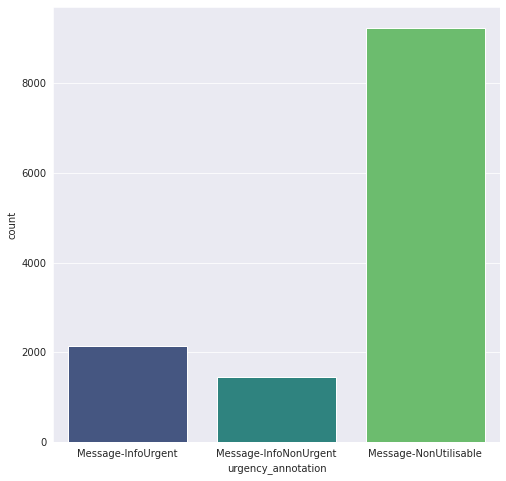

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')
plt.figure(figsize = (8, 8))
sns.countplot(x = data['urgency_annotation'] , palette = 'viridis')
plt.show()

In [ ]:
data['relatedness_annotation'].value_counts()

Message-NonUtilisable    9237
Message-Utilisable       3589
Name: relatedness_annotation, dtype: int64

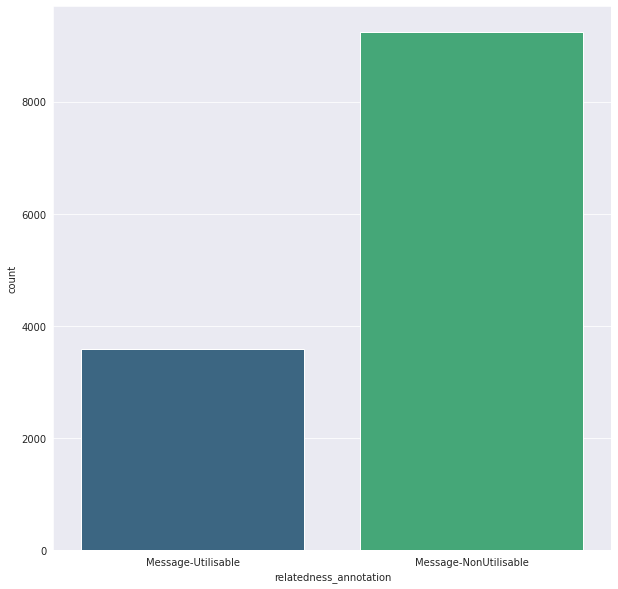

In [ ]:
sns.set_style('darkgrid')
plt.figure(figsize = (10, 10))
sns.countplot(x = data['relatedness_annotation'] , palette = 'viridis')
plt.show()

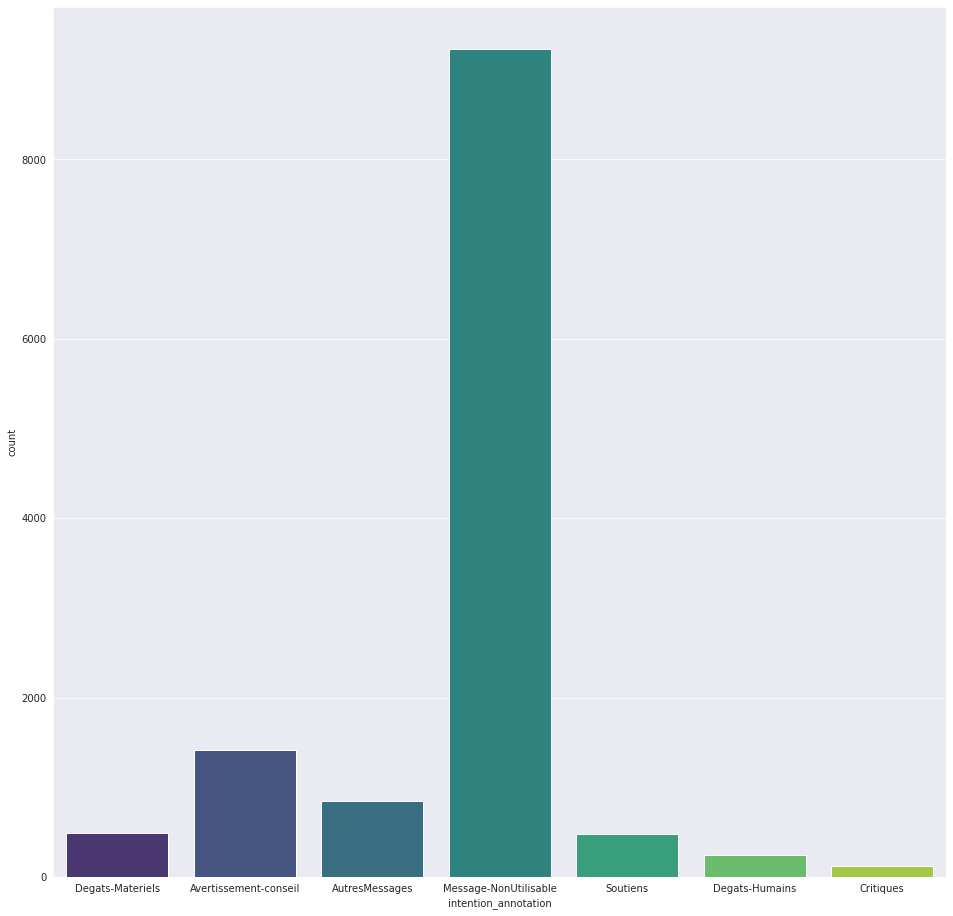

In [ ]:
sns.set_style('darkgrid')
plt.figure(figsize = (16, 16))
sns.countplot(x = data['intention_annotation'] , palette = 'viridis')
plt.show()

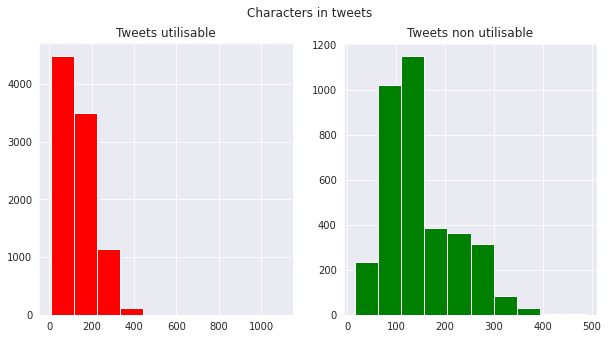

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=data[data['urgency_annotation']=='Message-NonUtilisable']['Tweet'].str.len()

ax1.hist(tweet_len,color='red')
ax1.set_title('Tweets non utilisable')
tweet_len=data[data['urgency_annotation']!='Message-NonUtilisable']['Tweet'].str.len()
ax2.hist(tweet_len,color='green')
ax2.set_title('Tweets utilisable')
fig.suptitle('Characters in tweets')
plt.show()

**Partie 01:** ALGORITHMES DE CLASSIFICATION SANS PRE TRAITEMENTS

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split  
from sklearn.ensemble import RandomForestClassifier


In [ ]:
def create_data_useful(data):
  X= data.iloc[:, 1].values  
  y = data.iloc[:, 4].values
  y = pd.factorize(y)
  y = y[0]
  return X,y

def create_data_urgency(data):
  X = data[~data['urgency_annotation'].isin(['Message-NonUtilisable'])]
  x = X.iloc[:, 1].values
  y = X.iloc[:, 5].values
  y = pd.factorize(y)
  y = y[0]
  return x,y

def Split_train(X,y):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
  return X_train, X_test, y_train, y_test


# PART 01: Tweet utilisable vs inutilisable

**SPLIT en TRAIN/TEST**

In [ ]:
X,y = create_data_useful(data)
X_train, X_test, y_train, y_test = Split_train(X,y)

# Print shape X_train, X_test + nb examples per class

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer  
#tfidfconverter = TfidfVectorizer(max_features=11110,
#                             use_idf=True,)
tfidfconverter = TfidfVectorizer(use_idf=True)    
X_train_vect = tfidfconverter.fit_transform(X_train).toarray() #fit appliqué qu'au train)
print(X_train_vect.shape)

(10260, 28886)


In [ ]:
tfidfconverter = TfidfVectorizer(max_features=11110,
                             use_idf=True,)
X_train_vect = tfidfconverter.fit_transform(X_train).toarray()
print(X_train_vect.shape)

(10260, 11110)


In [ ]:
X_test_vect = tfidfconverter.transform(X_test).toarray()
print(X_test_vect.shape)

(2566, 11110)


**Fonction d'optimisation des hyperparamètres :**

In [ ]:
from sklearn.model_selection import GridSearchCV
import numpy as np

def grid_search(model, params, X,y):
  grid = GridSearchCV(model,params,cv=4)
  grid.fit(X,y)
  return grid

In [ ]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score
from sklearn.model_selection import KFold

## Appretissage supervisé sans pré-traitement

### Random forest

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 1000, stop = 2000, num = 3)]
# Number of features to consider at every split
max_features = ['sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 50, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 8]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
bootstrap = [True, False]
param_grid = { 'n_estimators': n_estimators,
               #'max_features': max_features,
               #'max_depth': max_depth,
               #'min_samples_split': min_samples_split,
               #'min_samples_leaf': min_samples_leaf,
               #'bootstrap': bootstrap
              } 
grid = grid_search(RandomForestClassifier(),param_grid, X_train_vect,y_train)
#model = RandomForestClassifier().fit(X_train_vect,y_train)
#train_score, val_score = validation_curve(model,X_train_vect, y_train,'n_estimators',k,cv=4)

#plt.plot(k,val_score.mean(axis=1))

#predictions = text_classifier.predict(X_test_vect)
#cm=(confusion_matrix(y_test,predictions))  
#print(classification_report(y_test,predictions))
#print(accuracy_score(y_test, predictions))
#sns.heatmap(data=cm,fmt='.0f',xticklabels=np.unique(y),yticklabels=np.unique(y),annot=True)


GridSearchCV(cv=2, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=False, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='sqrt',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=1000, n_jobs=None,
                                              oob_score=False,
                                              ran

In [ ]:
print(grid.best_score_)
print(grid.best_params_)  # n estimators = 500 |1000/sqrt/boostrap = false/ None
model = grid.best_estimator_
model.score(X_test_vect,y_test)
predictions = model.predict(X_test_vect)
cm=(confusion_matrix(y_test,predictions))  
print(classification_report(y_test,predictions))
print(accuracy_score(y_test, predictions))
sns.heatmap(data=cm,fmt='.0f',xticklabels=np.unique(y),yticklabels=np.unique(y),annot=True)


NameError: ignored

              precision    recall  f1-score   support

           0       0.85      0.96      0.90      1828
           1       0.86      0.59      0.70       738

    accuracy                           0.85      2566
   macro avg       0.86      0.77      0.80      2566
weighted avg       0.85      0.85      0.84      2566

0.853078721745908


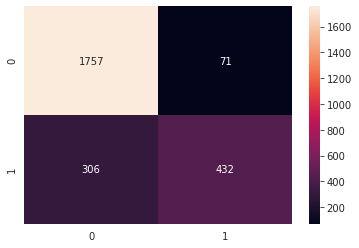

In [ ]:
text_classifier = RandomForestClassifier(n_estimators=1000, random_state=0,max_features='sqrt',bootstrap=False,min_samples_split=8,min_samples_leaf=1)  
text_classifier.fit(X_train_vect, y_train)
predictions = text_classifier.predict(X_test_vect)
cm=(confusion_matrix(y_test,predictions))  
print(classification_report(y_test,predictions))
print(accuracy_score(y_test, predictions))
sns.heatmap(data=cm,fmt='.0f',xticklabels=np.unique(y),yticklabels=np.unique(y),annot=True)


In [ ]:
print("Accuracy")
print(accuracy_score(y_test, predictions))
print("Précision : ")
print(precision_score(y_test,predictions))

Accuracy
0.853078721745908
Précision : 
0.8588469184890656


### Naives Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB


alpha = [int(x) for x in np.linspace(start = 1, stop = 10, num = 100)]
#binarizer__threshold =  [float(x) for x in np.linspace(start = 0, stop = 10, num = 100)]
#print(binarizer__threshold)
#print(alpha)
var = np.logspace(0,-9, num=100)
print(var)
params_NB = {
              'alpha' : alpha,
               'fit_prior': [True, False], 
             }
gs_NB = grid_search(MultinomialNB(),params_NB,X_train_vect,y_train)
print(gs_NB.best_params_)
#BNBmodel = BernoulliNB(alpha = 2)
#BNBmodel.fit(X_train_vect, y_train)
#predictions = BNBmodel.predict(X_test_vect)
#cm=confusion_matrix(y_test,predictions)  
#print(classification_report(y_test,predictions))  
#print(accuracy_score(y_test, predictions))
#sns.heatmap(data=cm,fmt='.0f',xticklabels=np.unique(y),yticklabels=np.unique(y),annot=True)


[1.00000000e+00 8.11130831e-01 6.57933225e-01 5.33669923e-01
 4.32876128e-01 3.51119173e-01 2.84803587e-01 2.31012970e-01
 1.87381742e-01 1.51991108e-01 1.23284674e-01 1.00000000e-01
 8.11130831e-02 6.57933225e-02 5.33669923e-02 4.32876128e-02
 3.51119173e-02 2.84803587e-02 2.31012970e-02 1.87381742e-02
 1.51991108e-02 1.23284674e-02 1.00000000e-02 8.11130831e-03
 6.57933225e-03 5.33669923e-03 4.32876128e-03 3.51119173e-03
 2.84803587e-03 2.31012970e-03 1.87381742e-03 1.51991108e-03
 1.23284674e-03 1.00000000e-03 8.11130831e-04 6.57933225e-04
 5.33669923e-04 4.32876128e-04 3.51119173e-04 2.84803587e-04
 2.31012970e-04 1.87381742e-04 1.51991108e-04 1.23284674e-04
 1.00000000e-04 8.11130831e-05 6.57933225e-05 5.33669923e-05
 4.32876128e-05 3.51119173e-05 2.84803587e-05 2.31012970e-05
 1.87381742e-05 1.51991108e-05 1.23284674e-05 1.00000000e-05
 8.11130831e-06 6.57933225e-06 5.33669923e-06 4.32876128e-06
 3.51119173e-06 2.84803587e-06 2.31012970e-06 1.87381742e-06
 1.51991108e-06 1.232846

              precision    recall  f1-score   support

           0       0.86      0.93      0.89      1828
           1       0.78      0.64      0.70       738

    accuracy                           0.84      2566
   macro avg       0.82      0.78      0.80      2566
weighted avg       0.84      0.84      0.84      2566

Accuracy
0.8425565081839439
Précision : 
0.7764900662251656


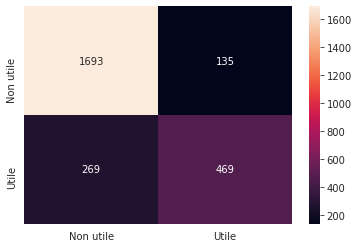

In [ ]:
BNBmodel = gs_NB.best_estimator_
BNBmodel.fit(X_train_vect, y_train)
predictions = BNBmodel.predict(X_test_vect)
cm=confusion_matrix(y_test,predictions)  
print(classification_report(y_test,predictions))  
print("Accuracy")
print(accuracy_score(y_test, predictions))
print("Précision : ")
print(precision_score(y_test,predictions))
sns.heatmap(data=cm,fmt='.0f',xticklabels=np.unique(['Utile','Non utile']),yticklabels=np.unique(['Utile','Non utile']),annot=True)


### Perceptron

In [ ]:
from sklearn.linear_model import Perceptron

penalty = ['l2','l1','elasticnet',None]
alpha = [float(x) for x in np.linspace(start = 0, stop = 10, num = 20)]
tol = [float(x) for x in np.linspace(start=0.0001, stop = 1, num = 10)]
params_PR = {'penalty':penalty,
             'alpha':alpha,
             'tol':tol}

grid_PR=grid_search(Perceptron(),params_PR,X_train_vect,y_train)
print(grid_PR.best_estimator_)
#clf = Perceptron(tol=1e-3, random_state=0)
#clf.fit(X_train_vect,y_train)
#predictions  = clf.predict(X_test_vect)
#cm=confusion_matrix(y_test,predictions) 
#print(classification_report(y_test,predictions))  
#print(accuracy_score(y_test, predictions))
#sns.heatmap(data=cm,fmt='.0f',xticklabels=np.unique(y),yticklabels=np.unique(y),annot=True)


Perceptron(alpha=0.0, class_weight=None, early_stopping=False, eta0=1.0,
           fit_intercept=True, max_iter=1000, n_iter_no_change=5, n_jobs=None,
           penalty='l2', random_state=0, shuffle=True, tol=0.0001,
           validation_fraction=0.1, verbose=0, warm_start=False)


              precision    recall  f1-score   support

           0       0.87      0.91      0.89      1828
           1       0.74      0.66      0.69       738

    accuracy                           0.83      2566
   macro avg       0.80      0.78      0.79      2566
weighted avg       0.83      0.83      0.83      2566

Accuracy
0.833593141075604
Précision : 
0.7366818873668188


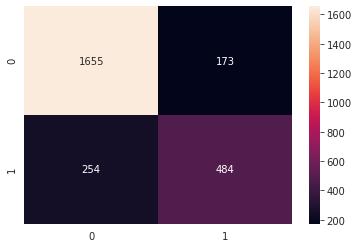

In [ ]:
from sklearn.linear_model import Perceptron

model_PR = Perceptron(alpha=0.0, class_weight=None, early_stopping=False, eta0=1.0,
           fit_intercept=True, max_iter=1000, n_iter_no_change=5, n_jobs=None,
           penalty='l2', random_state=0, shuffle=True, tol=0.0001,
           validation_fraction=0.1, verbose=0, warm_start=False)
model_PR.fit(X_train_vect,y_train)
#model_PR=grid_PR.best_estimator_
#print(grid_PR.best_params_)
predictions  = model_PR.predict(X_test_vect)
cm=confusion_matrix(y_test,predictions) 
print(classification_report(y_test,predictions))  
print("Accuracy")
print(accuracy_score(y_test, predictions))
print("Précision : ")
print(precision_score(y_test,predictions))
sns.heatmap(data=cm,fmt='.0f',xticklabels=np.unique(y),yticklabels=np.unique(y),annot=True)

### Logistic Regression*

In [ ]:
from sklearn.linear_model import LogisticRegression

param_LR = {'penalty' : ['l1', 'l2'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['liblinear']}
model_lr = LogisticRegression(tol=1e-3, random_state=0)
#LogisticRegression().get_params().keys()
grid_LR = grid_search(model_lr,param_LR,X_train_vect,y_train)
#clf.fit(X_train_vect,y_train)
#predictions  = clf.predict(X_test_vect)
#cm=confusion_matrix(y_test,predictions) 
#print(classification_report(y_test,predictions))  
#print(accuracy_score(y_test, predictions))
#sns.heatmap(data=cm,fmt='.0f',xticklabels=np.unique(y),yticklabels=np.unique(y),annot=True)

              precision    recall  f1-score   support

           0       0.88      0.94      0.91      1828
           1       0.82      0.68      0.74       738

    accuracy                           0.87      2566
   macro avg       0.85      0.81      0.83      2566
weighted avg       0.86      0.87      0.86      2566

Accuracy
0.8655494933749026
Précision : 
0.8226600985221675


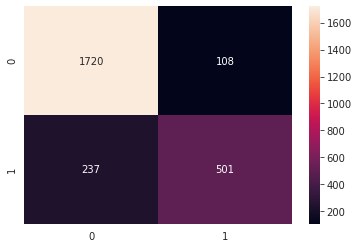

In [ ]:
from sklearn.linear_model import LogisticRegression

#model_lr=grid_LR.best_estimator_
#print(grid_LR.best_params_)
#print(grid_LR.best_score_)
model_lr = LogisticRegression(C= 4.281332398719396, penalty= 'l2', solver= 'liblinear')
model_lr.fit(X_train_vect, y_train)
predictions  = model_lr.predict(X_test_vect)
cm=confusion_matrix(y_test,predictions) 
print(classification_report(y_test,predictions))  
print("Accuracy")
print(accuracy_score(y_test, predictions))
print("Précision : ")
print(precision_score(y_test,predictions))
sns.heatmap(data=cm,fmt='.0f',xticklabels=np.unique(y),yticklabels=np.unique(y),annot=True)


## Apprentissage supervisée avec pré-traitement

**Text preprocess**


1.   Lower Casing.
2.   Spell checker
3.   Lemmatizing
4.   Tokenization







In [ ]:
import spacy
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import FrenchStemmer


spacy.cli.download("fr_core_news_sm")

nlp = spacy.load("fr_core_news_sm")


stemmer = FrenchStemmer()
nltk.download('stopwords')
stopword = nltk.corpus.stopwords.words('french')


✔ Download and installation successful
You can now load the model via spacy.load('fr_core_news_sm')
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def remove_punct(text):
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    return text

def replaceURL(text):
    """ Replaces url address with "url" """
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','',text)
    text = re.sub(r'#([^\s]+)', r'\1', text)
    return text

def replaceAtUser(text):
    """ Replaces "@user" with "atUser" """
    text = re.sub('@[^\s]+','',text)
    return text

def removeHashtagInFrontOfWord(text):
    text = re.sub(r'#([^\s]+)', r'\1', text)
    return text

def removeNumbers(text):
    """ Removes integers """
    text = ''.join([i for i in text if not i.isdigit()])         
    return text

def remove_stopwords(text):
    text = ''.join([i for i in text if i not in stopword])   
    return text

def removeEmoticons(text):
    """ Removes emoticons from text """
    text = re.sub(':\)|;\)|:-\)|\(-:|:-D|=D|:P|xD|X-p|\^\^|:-*|\^\.\^|\^\-\^|\^\_\^|\,-\)|\)-:|:\'\(|:\(|:-\(|:\S|T\.T|\.\_\.|:<|:-\S|:-<|\*\-\*|:O|=O|=\-O|O\.o|XO|O\_O|:-\@|=/|:/|X\-\(|>\.<|>=\(|D:', '', text)
    return text

def preprocess(text):
  text = replaceAtUser(text)
  text = replaceURL(text)
  text = removeHashtagInFrontOfWord(text)
  text = removeNumbers(text)
  text = removeEmoticons(text)
  text = remove_punct(text.lower())
  #text = remove_stopwords(text)
  text = stemming(text)
  return text

def return_token(sentence):
    # Tokeniser la phrase
    doc = nlp(sentence)
    # Retourner le texte de chaque token
    return [X.text for X in doc]


def stemming(text):
  doc = nlp(text)
  token = [X.text for X in doc]
  mot_data  = ' '.join(stemmer.stem(str(v)) for v in token)
  return mot_data


In [ ]:
x=[]
for i in X:
  x.append(preprocess(i))

In [ ]:
def remove_special_characters_and_url(text, remove_digits=False):
    #pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    #text = re.sub(pattern, '', text)
    #' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",x).split())

    result = re.sub(r"http\S+", "", text.lower())
    result = re.sub("(@[A-Za-z0-9]+)|(#\S+)|(\w+:\/\/\S+)|(pic.twitter.com\S+)"," ", result)
    result = result.translate(str.maketrans('', '', string.punctuation))
    return result

data_all = []
for i in X:
  #mot_corrigé = spell.correction(i.lower()).split()
  #print(mot_corrigé)
  mot=remove_special_characters_and_url(i,remove_digits=False)
  lem = nlp(mot)
  mot_corrigé = []
  mot_data = ''
  for le in lem:
    mot_corrigé.append(le.lemma_)
    #mot_data = ' '.join(str(le))
  mot_data  = ' '.join(str(v) for v in mot_corrigé)
  data_all.append(mot_data.strip())
print(data_all)

['merci    pour le relai de notre appel pour aider le population toucher par l  \xa0 …', 'pour lyon c’ être simple un coach incompéter un président qui avoir plus d’ ambition juste le minimum syndical voilà un réponse monaco c’ être de business et marseill être nul tout simplement', 'le martinique cest magnifique et le antillais être hyper sympas franchement gros love', 'un homme sauve un chat pendant un inondation en inde en 2011', '12 pour marseill    …', 'super chier ce réunion orientation ptn', 'il de porquerolle 83 fr 21012018 0200    tempête maxi 106 kmh de louest    …', 'video inondation dans l’ aude \xa0  ce que l’ on savoir de ce évènement climatique meurtrier    … via', 'le wifi marche pas olala ya sans doute avoir un coupure avec le tempête', 'selon as le club avoir l’ intention de faire signer l’ attaquant portugais de   fr bruno gama 30 an le club cherche vraiment un alternatif suite al blessure de notre deux ailier', 'le rosace de le cathédrale de    largement endommager 

In [ ]:
X_train, X_test, y_train, y_test = Split_train(x,y)


In [ ]:
X_train

['inond   le secour sont débord le pompi de départ voisin appel en renfort leau continu de mont dan laud inond',
 'vigil orang pluieinond et orag soi prudent   beaucair',
 'la tempêt bruno est situ au larg de la bretagn ce soir renforc du vent la nuit prochain sur la façad atlant avec de orag pouv être local fortspictwittercomfjyxcnwjpf',
 'solidar outrem   le pre macron bientôt aux antill apres louraganirm lesactesvalentmieuxquelesmot \xa0 …',
 'la ministr de la justic a été hu en cors \n  rentr à paris hurlent de grévist \n  oui en effet je vais rentr à paris leur répond nicolebelloubet \n  pourvu quil yait une tempêt quand vous ser dan lavion   clam un gardien de prison en coler \n ambianc',
 'portovecchiol chiapp a fr      tempêt max   kmh du sudouest \xa0 …',
 'heureux que vous vous « \xa0 autogratul \xa0 » entre vous sérieux vous ne remarqu pas la décept de cors à tous le niveau à part dan la méthod cou et l’ autosatisfact à coup de communicationvous ne brill pas beaucoupcors',
 

In [ ]:
tfidfconverter = TfidfVectorizer(max_features=11110,
                             use_idf=True)  
X_train_vect = tfidfconverter.fit_transform(X_train).toarray()
X_test_vect = tfidfconverter.transform(X_test).toarray()

### Random forest 

              precision    recall  f1-score   support

           0       0.82      0.59      0.69       720
           1       0.86      0.95      0.90      1846

    accuracy                           0.85      2566
   macro avg       0.84      0.77      0.80      2566
weighted avg       0.85      0.85      0.84      2566

Accuracy :
0.8503507404520655
Précision : 
0.85693359375


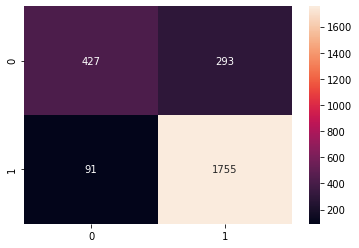

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model=RandomForestClassifier(n_estimators=1000,max_features = 'sqrt',bootstrap=False)
model.fit(X_train_vect,y_train)
model.score(X_test_vect,y_test)
predictions = model.predict(X_test_vect)
cm=(confusion_matrix(y_test,predictions))  
print(classification_report(y_test,predictions))
print("Accuracy :")
print(accuracy_score(y_test, predictions))
print("Précision : ")
print(precision_score(y_test,predictions))
sns.heatmap(data=cm,fmt='.0f',xticklabels=np.unique(y),yticklabels=np.unique(y),annot=True)

{'alpha': 1, 'binarize': 0.11111111111111112, 'fit_prior': True}
              precision    recall  f1-score   support

           0       0.87      0.92      0.89      1861
           1       0.76      0.62      0.68       705

    accuracy                           0.84      2566
   macro avg       0.81      0.77      0.79      2566
weighted avg       0.84      0.84      0.84      2566

0.8409976617303195


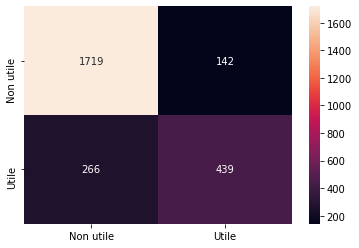

In [ ]:
from sklearn.naive_bayes import BernoulliNB

alpha = [int(x) for x in np.linspace(start = 1, stop = 10, num = 10)]
binarizer__threshold =  [float(x) for x in np.linspace(start = 0, stop = 0.2, num = 10)]
#print(binarizer__threshold)
#print(alpha)
params_NB = {
              'alpha' : alpha,
               'fit_prior': [True, False], 
             'binarize': binarizer__threshold,
             }
gs_NB = grid_search(BernoulliNB(),params_NB,X_train_vect,y_train)
print(gs_NB.best_params_)
BNBmodel = gs_NB.best_estimator_
BNBmodel.fit(X_train_vect, y_train)
predictions = BNBmodel.predict(X_test_vect)
cm=confusion_matrix(y_test,predictions)  
print(classification_report(y_test,predictions))  
print(accuracy_score(y_test, predictions))#
sns.heatmap(data=cm,fmt='.0f',xticklabels=np.unique(['Utile','Non utile']),yticklabels=np.unique(['Utile','Non utile']),annot=True)



### naive bayes

              precision    recall  f1-score   support

           0       0.73      0.69      0.71       720
           1       0.88      0.90      0.89      1846

    accuracy                           0.84      2566
   macro avg       0.81      0.80      0.80      2566
weighted avg       0.84      0.84      0.84      2566

Accuracy :
0.8417770849571318
Précision : 
0.8817603393425238


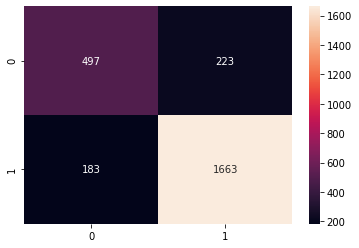

In [ ]:
from sklearn.naive_bayes import BernoulliNB

Model_br = BernoulliNB(alpha= 1, binarize= 0.11111111111111112, fit_prior= True)
Model_br.fit(X_train_vect,y_train)
Model_br.score(X_test_vect,y_test)
predictions = Model_br.predict(X_test_vect)
cm=(confusion_matrix(y_test,predictions))  
print(classification_report(y_test,predictions))
print("Accuracy :")
print(accuracy_score(y_test, predictions))
print("Précision : ")
print(precision_score(y_test,predictions))
sns.heatmap(data=cm,fmt='.0f',xticklabels=np.unique(y),yticklabels=np.unique(y),annot=True)

### perceptron

In [ ]:
from sklearn.linear_model import Perceptron

penalty = ['l2','l1','elasticnet',None]
alpha = [float(x) for x in np.linspace(start = 0, stop = 10, num = 20)]
tol = [float(x) for x in np.linspace(start=0.0001, stop = 1, num = 10)]
params_PR = {'penalty':penalty,
             'alpha':alpha,
             'tol':tol}

grid_PR=grid_search(Perceptron(),params_PR,X_train_vect,y_train)
print(grid_PR.best_estimator_)

Perceptron(alpha=0.0, class_weight=None, early_stopping=False, eta0=1.0,
           fit_intercept=True, max_iter=1000, n_iter_no_change=5, n_jobs=None,
           penalty='l2', random_state=0, shuffle=True, tol=0.11120000000000001,
           validation_fraction=0.1, verbose=0, warm_start=False)


              precision    recall  f1-score   support

           0       0.52      0.84      0.64       720
           1       0.92      0.70      0.79      1846

    accuracy                           0.74      2566
   macro avg       0.72      0.77      0.72      2566
weighted avg       0.81      0.74      0.75      2566

Accuracy :
0.7388932190179267
Précision : 
0.9170212765957447


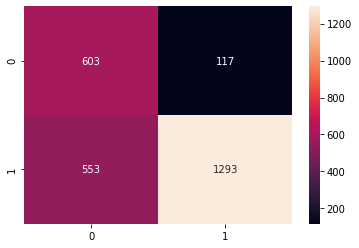

In [ ]:
from sklearn.linear_model import Perceptron
model_pc = Perceptron(alpha=0,penalty='l2',tol=0.0001)
model_pc.fit(X_train_vect,y_train)
model_pc.score(X_test_vect,y_test)
predictions = model_pc.predict(X_test_vect)
cm=(confusion_matrix(y_test,predictions))  
print(classification_report(y_test,predictions))
print("Accuracy :")
print(accuracy_score(y_test, predictions))
print("Précision : ")
print(precision_score(y_test,predictions))
sns.heatmap(data=cm,fmt='.0f',xticklabels=np.unique(y),yticklabels=np.unique(y),annot=True)

### Logistic Regression

              precision    recall  f1-score   support

           0       0.68      0.79      0.73       720
           1       0.91      0.86      0.88      1846

    accuracy                           0.84      2566
   macro avg       0.80      0.82      0.81      2566
weighted avg       0.85      0.84      0.84      2566

Accuracy :
0.8374902572096649
Précision : 
0.9118155619596542


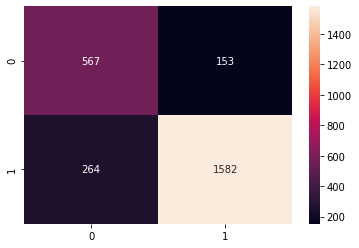

In [ ]:
from sklearn.linear_model import LogisticRegression
model_log = LogisticRegression(C= 4.281332398719396, penalty ='l2', solver= 'liblinear',class_weight="balanced")
model_log.fit(X_train_vect,y_train)
model_log.score(X_test_vect,y_test)
predictions = model_log.predict(X_test_vect)
cm=(confusion_matrix(y_test,predictions))  
print(classification_report(y_test,predictions))
print("Accuracy :")
print(accuracy_score(y_test, predictions))
print("Précision : ")
print(precision_score(y_test,predictions))
sns.heatmap(data=cm,fmt='.0f',xticklabels=np.unique(y),yticklabels=np.unique(y),annot=True)

# PART 02: Tweet Urgent vs non urgent.

In [ ]:
X,y = create_data_urgency(data)
X_train, X_test, y_train, y_test = Split_train(X,y)

## Apprentissage supervisé sans pré-traitement

In [ ]:
tfidfconverter = TfidfVectorizer(max_features=11110,
                             use_idf=True)
X_train_vect = tfidfconverter.fit_transform(X_train).toarray()
print(X_train_vect.shape)
X_test_vect = tfidfconverter.transform(X_test).toarray()
print(X_test_vect.shape)

(2871, 9386)
(718, 9386)


### Random Forest

              precision    recall  f1-score   support

           0       0.86      0.88      0.87       446
           1       0.80      0.77      0.79       272

    accuracy                           0.84       718
   macro avg       0.83      0.83      0.83       718
weighted avg       0.84      0.84      0.84       718

0.8398328690807799


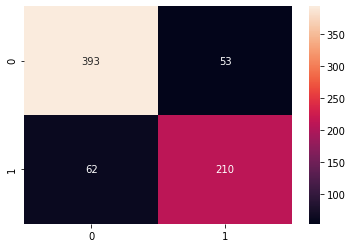

In [ ]:
text_classifier = RandomForestClassifier(n_estimators=1000, random_state=0,max_features='sqrt',bootstrap=False,min_samples_split=8,min_samples_leaf=1)  
text_classifier.fit(X_train_vect, y_train)
predictions = text_classifier.predict(X_test_vect)
cm=(confusion_matrix(y_test,predictions))  
print(classification_report(y_test,predictions))
print(accuracy_score(y_test, predictions))
sns.heatmap(data=cm,fmt='.0f',xticklabels=np.unique(y),yticklabels=np.unique(y),annot=True)

### Naive Bayes

              precision    recall  f1-score   support

           0       0.85      0.91      0.88       446
           1       0.83      0.73      0.78       272

    accuracy                           0.84       718
   macro avg       0.84      0.82      0.83       718
weighted avg       0.84      0.84      0.84       718

Accuracy :
0.841225626740947
Précision : 
0.8319327731092437


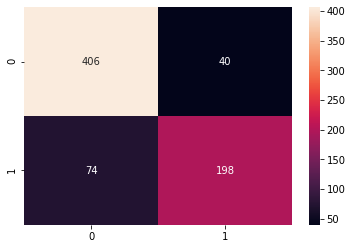

In [ ]:
Model_br = BernoulliNB(alpha= 1, binarize= 0.11111111111111112, fit_prior= True)
Model_br.fit(X_train_vect,y_train)
Model_br.score(X_test_vect,y_test)
predictions = Model_br.predict(X_test_vect)
cm=(confusion_matrix(y_test,predictions))  
print(classification_report(y_test,predictions))
print("Accuracy :")
print(accuracy_score(y_test, predictions))
print("Précision : ")
print(precision_score(y_test,predictions))
sns.heatmap(data=cm,fmt='.0f',xticklabels=np.unique(y),yticklabels=np.unique(y),annot=True)

### Perceptron

              precision    recall  f1-score   support

           0       0.88      0.86      0.87       446
           1       0.78      0.82      0.80       272

    accuracy                           0.84       718
   macro avg       0.83      0.84      0.84       718
weighted avg       0.85      0.84      0.84       718

Accuracy :
0.8440111420612814
Précision : 
0.7816901408450704


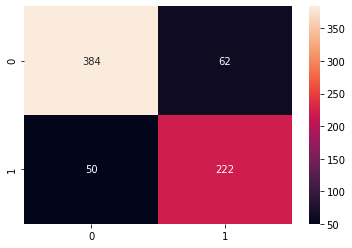

In [ ]:
model_pc = Perceptron(alpha=0,penalty='l2',tol=0.0001)
model_pc.fit(X_train_vect,y_train)
model_pc.score(X_test_vect,y_test)
predictions = model_pc.predict(X_test_vect)
cm=(confusion_matrix(y_test,predictions))  
print(classification_report(y_test,predictions))
print("Accuracy :")
print(accuracy_score(y_test, predictions))
print("Précision : ")
print(precision_score(y_test,predictions))
sns.heatmap(data=cm,fmt='.0f',xticklabels=np.unique(y),yticklabels=np.unique(y),annot=True)

### Logistic Regression

              precision    recall  f1-score   support

           0       0.92      0.85      0.88       446
           1       0.78      0.87      0.82       272

    accuracy                           0.86       718
   macro avg       0.85      0.86      0.85       718
weighted avg       0.86      0.86      0.86       718

Accuracy :
0.8565459610027855
Précision : 
0.7770491803278688


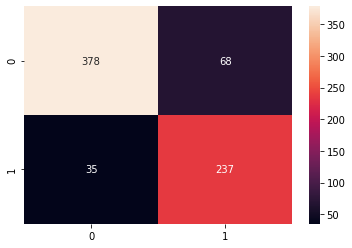

In [ ]:
model_log = LogisticRegression(C= 4.281332398719396, penalty ='l2', solver= 'liblinear',class_weight="balanced")
model_log.fit(X_train_vect,y_train)
model_log.score(X_test_vect,y_test)
predictions = model_log.predict(X_test_vect)
cm=(confusion_matrix(y_test,predictions))  
print(classification_report(y_test,predictions))
print("Accuracy :")
print(accuracy_score(y_test, predictions))
print("Précision : ")
print(precision_score(y_test,predictions))
sns.heatmap(data=cm,fmt='.0f',xticklabels=np.unique(y),yticklabels=np.unique(y),annot=True)

## Apprentissage supervisé avec pré-traitement

In [ ]:
x=[]
for i in X:
  x.append(preprocess(i))

In [ ]:
X_train, X_test, y_train, y_test = Split_train(x,y)


In [ ]:
tfidfconverter = TfidfVectorizer(max_features=11110,
                             use_idf=True)  
X_train_vect = tfidfconverter.fit_transform(X_train).toarray()
X_test_vect = tfidfconverter.transform(X_test).toarray()

### Random Forest

              precision    recall  f1-score   support

           0       0.88      0.87      0.88       446
           1       0.79      0.80      0.80       272

    accuracy                           0.85       718
   macro avg       0.84      0.84      0.84       718
weighted avg       0.85      0.85      0.85       718

Accuracy :
0.8454038997214485
Précision : 
0.7927272727272727


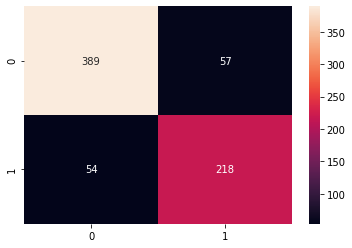

In [ ]:
model=RandomForestClassifier(n_estimators=1000,max_features = 'sqrt',bootstrap=False)
model.fit(X_train_vect,y_train)
model.score(X_test_vect,y_test)
predictions = model.predict(X_test_vect)
cm=(confusion_matrix(y_test,predictions))  
print(classification_report(y_test,predictions))
print("Accuracy :")
print(accuracy_score(y_test, predictions))
print("Précision : ")
print(precision_score(y_test,predictions))
sns.heatmap(data=cm,fmt='.0f',xticklabels=np.unique(y),yticklabels=np.unique(y),annot=True)

### Naive Bayes

              precision    recall  f1-score   support

           0       0.85      0.90      0.87       446
           1       0.82      0.73      0.77       272

    accuracy                           0.84       718
   macro avg       0.83      0.82      0.82       718
weighted avg       0.83      0.84      0.83       718

Accuracy :
0.8356545961002786
Précision : 
0.8155737704918032


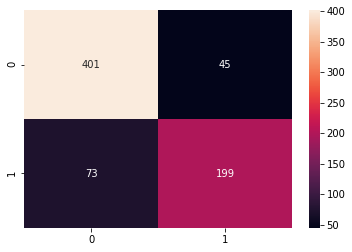

In [ ]:

Model_br = BernoulliNB(alpha= 1, binarize= 0.11111111111111112, fit_prior= True)
Model_br.fit(X_train_vect,y_train)
Model_br.score(X_test_vect,y_test)
predictions = Model_br.predict(X_test_vect)
cm=(confusion_matrix(y_test,predictions))  
print(classification_report(y_test,predictions))
print("Accuracy :")
print(accuracy_score(y_test, predictions))
print("Précision : ")
print(precision_score(y_test,predictions))
sns.heatmap(data=cm,fmt='.0f',xticklabels=np.unique(y),yticklabels=np.unique(y),annot=True)

### Perceptron

              precision    recall  f1-score   support

           0       0.90      0.83      0.86       446
           1       0.75      0.84      0.80       272

    accuracy                           0.84       718
   macro avg       0.82      0.84      0.83       718
weighted avg       0.84      0.84      0.84       718

Accuracy :
0.8356545961002786
Précision : 
0.7532894736842105


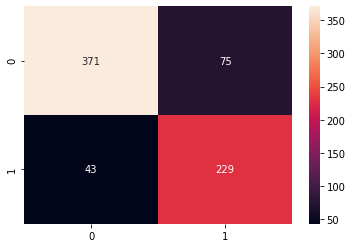

In [ ]:
from sklearn.linear_model import Perceptron
model_pc = Perceptron(alpha=0,penalty='l2',tol=0.0001)
model_pc.fit(X_train_vect,y_train)
model_pc.score(X_test_vect,y_test)
predictions = model_pc.predict(X_test_vect)
cm=(confusion_matrix(y_test,predictions))  
print(classification_report(y_test,predictions))
print("Accuracy :")
print(accuracy_score(y_test, predictions))
print("Précision : ")
print(precision_score(y_test,predictions))
sns.heatmap(data=cm,fmt='.0f',xticklabels=np.unique(y),yticklabels=np.unique(y),annot=True)

### Logistic Regression

              precision    recall  f1-score   support

           0       0.92      0.84      0.88       446
           1       0.77      0.88      0.82       272

    accuracy                           0.85       718
   macro avg       0.84      0.86      0.85       718
weighted avg       0.86      0.85      0.86       718

Accuracy :
0.8537604456824512
Précision : 
0.7702265372168284


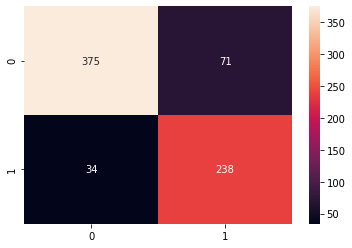

In [ ]:
model_log = LogisticRegression(C= 4.281332398719396, penalty ='l2', solver= 'liblinear',class_weight="balanced")
model_log.fit(X_train_vect,y_train)
model_log.score(X_test_vect,y_test)
predictions = model_log.predict(X_test_vect)
cm=(confusion_matrix(y_test,predictions))  
print(classification_report(y_test,predictions))
print("Accuracy :")
print(accuracy_score(y_test, predictions))
print("Précision : ")
print(precision_score(y_test,predictions))
sns.heatmap(data=cm,fmt='.0f',xticklabels=np.unique(y),yticklabels=np.unique(y),annot=True)

# Part 03: crisis classification

In [ ]:
def create_data_multi(data):
  data = shuffle(data)
  X = data[~data['intention_annotation'].isin(['Message-NonUtilisable'])]
  x = X.iloc[:, 1].values
  y = X.iloc[:, 6].values
  y = pd.factorize(y)
  y = y[0]
  return x, y

In [ ]:
X,y = create_data_multi(data)

In [ ]:
X_train, X_test, y_train, y_test = Split_train(X,y)

tfidfconverter = TfidfVectorizer(use_idf=True,max_features=11110)  
X_train_vect = tfidfconverter.fit_transform(X_train).toarray()
X_test_vect = tfidfconverter.transform(X_test).toarray()

In [ ]:
print(y_train)

[5 2 1 ... 5 0 5]


In [ ]:
from imblearn.over_sampling import SMOTE
sm = SMOTE()
resampled_training_inputs, resampled_training_outputs_labels = sm.fit_resample(X_train_vect, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/loca

              precision    recall  f1-score   support

           0       0.73      0.45      0.55       168
           1       0.89      0.79      0.84       296
           2       0.67      0.87      0.76        90
           3       0.21      0.58      0.30        24
           4       0.42      0.86      0.56        43
           5       0.78      0.63      0.70        97

    accuracy                           0.70       718
   macro avg       0.62      0.70      0.62       718
weighted avg       0.76      0.70      0.71       718

Accuracy :
0.6963788300835655


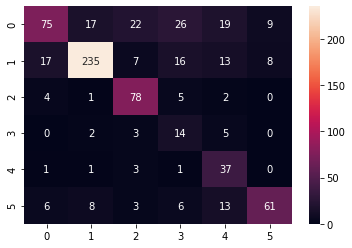

In [ ]:
from sklearn.naive_bayes import MultinomialNB

ovo = MultinomialNB()
ovo.fit(resampled_training_inputs, resampled_training_outputs_labels)
predictions = ovo.predict(X_test_vect)
cm=(confusion_matrix(y_test,predictions))  
print(classification_report(y_test,predictions))
print("Accuracy :")
print(accuracy_score(y_test, predictions))
#print("Précision : ")
#print(precision_score(y_test,predictions))
sns.heatmap(data=cm,fmt='.0f',xticklabels=np.unique(y),yticklabels=np.unique(y),annot=True)


In [ ]:
from sklearn.linear_model import LogisticRegression

param_LR = {'penalty' : ['l1', 'l2'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
model_lr = LogisticRegression(tol=1e-3, random_state=0)
#LogisticRegression().get_params().keys()
grid_LR = grid_search(model_lr,param_LR,X_train_vect,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_

In [ ]:
print(grid_LR.best_estimator_)

              precision    recall  f1-score   support

           0       0.64      0.67      0.66       168
           1       0.88      0.84      0.86       296
           2       0.74      0.86      0.79        90
           3       0.31      0.33      0.32        24
           4       0.78      0.81      0.80        43
           5       0.78      0.67      0.72        97

    accuracy                           0.76       718
   macro avg       0.69      0.70      0.69       718
weighted avg       0.77      0.76      0.76       718

Accuracy :
0.7618384401114207


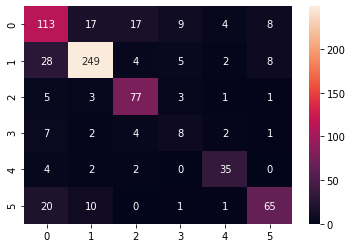

In [ ]:
from sklearn.multiclass import OneVsRestClassifier

model_log = LogisticRegression(C= 4.281332398719396, penalty ='l2', solver= 'lbfgs')
mod = OneVsRestClassifier(model_log)
mod.fit(resampled_training_inputs,resampled_training_outputs_labels)
mod.score(X_test_vect,y_test)
predictions = mod.predict(X_test_vect)
cm=(confusion_matrix(y_test,predictions))  
print(classification_report(y_test,predictions))
print("Accuracy :")
print(accuracy_score(y_test, predictions))
#print("Précision : ")
#print(precision_score(y_test,predictions))
sns.heatmap(data=cm,fmt='.0f',xticklabels=np.unique(y),yticklabels=np.unique(y),annot=True)

              precision    recall  f1-score   support

           0       0.62      0.62      0.62       168
           1       0.81      0.89      0.85       296
           2       0.81      0.82      0.82        90
           3       0.33      0.17      0.22        24
           4       0.60      0.84      0.70        43
           5       0.86      0.57      0.68        97

    accuracy                           0.75       718
   macro avg       0.67      0.65      0.65       718
weighted avg       0.75      0.75      0.74       718

Accuracy :
0.7465181058495822


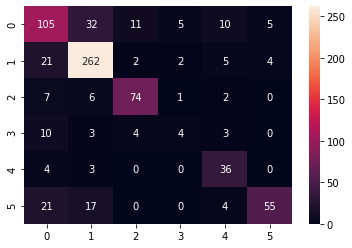

In [ ]:
model_pc = Perceptron(alpha=0,penalty='l2',tol=0.0001)
model_pc.fit(resampled_training_inputs,resampled_training_outputs_labels)
model_pc.score(X_test_vect,y_test)
predictions = model_pc.predict(X_test_vect)
cm=(confusion_matrix(y_test,predictions))  
print(classification_report(y_test,predictions))
print("Accuracy :")
print(accuracy_score(y_test, predictions))
sns.heatmap(data=cm,fmt='.0f',xticklabels=np.unique(y),yticklabels=np.unique(y),annot=True)

# Réseaux de neurones

In [ ]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.preprocessing.text import Tokenizer
import pandas as pd
from keras.layers.embeddings import Embedding

In [ ]:
y_enc=pd.get_dummies(y)


In [ ]:
labels = np.unique(y)
list(labels)

['AutresMessages',
 'Avertissement-conseil',
 'Critiques',
 'Degats-Humains',
 'Degats-Materiels',
 'Soutiens']

In [ ]:
from sklearn.preprocessing import OneHotEncoder
le = OneHotEncoder()
y_enc = le.fit_transform(y.reshape(-1,1)).toarray()

#y_labels = np.asarray(name_labels)


In [ ]:
X_train, X_test, y_train, y_test = Split_train(X,y_enc)


In [ ]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

x_tr_seq  = word_tokenizer.texts_to_sequences(X_train) 
x_val_seq = word_tokenizer.texts_to_sequences(X_test)


x_tr_seq  = pad_sequences(x_tr_seq, maxlen=100)
x_val_seq = pad_sequences(x_val_seq, maxlen=100)


In [ ]:
size_of_vocabulary=len(word_tokenizer.word_index) + 1 #+1 for padding
print(size_of_vocabulary)

10221


In [ ]:
from keras.models import *
from keras.layers import *
from keras.callbacks import *

model=Sequential()

#embedding layer
model.add(Embedding(size_of_vocabulary,300,input_length=100,trainable=True)) 

#lstm layer
model.add(LSTM(128,return_sequences=True,dropout=0.2)) # 256

#Global Maxpooling
model.add(GlobalMaxPooling1D())

#Dense Layer
model.add(Dense(64,activation='relu')) 
model.add(Dense(6,activation='sigmoid')) 

#Add loss function, metrics, optimizer
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy']) #sgd


#Add loss function, metrics, optimizer

#Adding callbacks
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=3)  
mc=ModelCheckpoint('model.h5', monitor='val_acc', mode='max', save_best_only=True,verbose=1)  

#Print summary of model
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 300)          3066300   
_________________________________________________________________
lstm_2 (LSTM)                (None, 100, 128)          219648    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 390       
Total params: 3,294,594
Trainable params: 3,294,594
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
history = model.fit(x_tr_seq,y_train,batch_size=128,epochs=10,validation_data=(x_val_seq,y_test),verbose=1,callbacks=[es,mc])

Epoch 1/10
23/23 [==============================] - 17s 638ms/step - loss: 1.6645 - categorical_accuracy: 0.3425 - val_loss: 1.4894 - val_categorical_accuracy: 0.4123
Epoch 2/10
23/23 [==============================] - 14s 605ms/step - loss: 1.4395 - categorical_accuracy: 0.4227 - val_loss: 1.1733 - val_categorical_accuracy: 0.5460
Epoch 3/10
23/23 [==============================] - 14s 607ms/step - loss: 1.1014 - categorical_accuracy: 0.5655 - val_loss: 0.9746 - val_categorical_accuracy: 0.6755
Epoch 4/10
23/23 [==============================] - 14s 605ms/step - loss: 0.7759 - categorical_accuracy: 0.7521 - val_loss: 0.8208 - val_categorical_accuracy: 0.7145
Epoch 5/10
23/23 [==============================] - 14s 609ms/step - loss: 0.4193 - categorical_accuracy: 0.8781 - val_loss: 0.8657 - val_categorical_accuracy: 0.7187
Epoch 6/10
23/23 [==============================] - 14s 604ms/step - loss: 0.2238 - categorical_accuracy: 0.9322 - val_loss: 0.8851 - val_categorical_accuracy: 0.735

In [ ]:
from keras.models import load_model

#evaluation 
_,val_acc = model.evaluate(x_val_seq,y_test, batch_size=128)
print(val_acc)

6/6 [==============================] - 1s 157ms/step - loss: 1.0114 - categorical_accuracy: 0.7159
0.7158774137496948


**Avec Word Embeddings :**

In [ ]:
# load the whole embedding into memory
embeddings_index = dict()
f = open("cc.fr.300.vec")
for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 2000000 word vectors.


In [ ]:
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 2000000 word vectors.


In [ ]:
import numpy as np

embedding_matrix = np.zeros((size_of_vocabulary, 300))

for word, i in word_tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
model=Sequential()

#embedding layer
model.add(Embedding(size_of_vocabulary,300,weights=[embedding_matrix],input_length=100,trainable=False)) 

#lstm layer
model.add(LSTM(128,return_sequences=True,dropout=0.2))

#Global Maxpooling
model.add(GlobalMaxPooling1D())

#Dense Layer
model.add(Dense(64,activation='relu')) 
model.add(Dense(6,activation='sigmoid')) 

#Add loss function, metrics, optimizer
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=["acc"]) 

#Adding callbacks
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=3)  
mc=ModelCheckpoint('best_model_em.h5', monitor='val_acc', mode='max', save_best_only=True,verbose=1)  

#Print summary of model
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 300)          3066300   
_________________________________________________________________
lstm_3 (LSTM)                (None, 100, 128)          219648    
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_7 (Dense)              (None, 6)                 390       
Total params: 3,294,594
Trainable params: 228,294
Non-trainable params: 3,066,300
_________________________________________________________________
None


In [ ]:
model = Sequential()
model.add(Embedding(size_of_vocabulary,300,weights=[embedding_matrix],input_length=100,trainable=False)) 
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(6, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 20
batch_size = 64

history = model.fit(np.array(x_tr_seq),np.array(y_train), epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


Epoch 1/20
41/41 [==============================] - 20s 425ms/step - loss: 1.6207 - accuracy: 0.3554 - val_loss: 1.2935 - val_accuracy: 0.5139
Epoch 2/20
41/41 [==============================] - 17s 420ms/step - loss: 1.3208 - accuracy: 0.4983 - val_loss: 1.1382 - val_accuracy: 0.5764
Epoch 3/20
41/41 [==============================] - 17s 417ms/step - loss: 1.2119 - accuracy: 0.5333 - val_loss: 1.0481 - val_accuracy: 0.6285
Epoch 4/20
41/41 [==============================] - 17s 417ms/step - loss: 1.0963 - accuracy: 0.6015 - val_loss: 0.9086 - val_accuracy: 0.6632
Epoch 5/20
41/41 [==============================] - 17s 417ms/step - loss: 1.0103 - accuracy: 0.6310 - val_loss: 0.8252 - val_accuracy: 0.7188
Epoch 6/20
41/41 [==============================] - 17s 419ms/step - loss: 0.9559 - accuracy: 0.6450 - val_loss: 0.7910 - val_accuracy: 0.7257
Epoch 7/20
41/41 [==============================] - 17s 418ms/step - loss: 0.9393 - accuracy: 0.6646 - val_loss: 0.7880 - val_accuracy: 0.7396

In [ ]:
history = model.fit(np.array(x_tr_seq),np.array(y_train),batch_size=128,epochs=10,validation_data=(np.array(x_val_seq),np.array(y_test)),verbose=1,callbacks=[es,mc])

Epoch 1/10
10/23 [============>.................] - ETA: 9s - loss: 0.9667 - accuracy: 0.6602

KeyboardInterrupt: ignored

In [ ]:
from keras.models import load_model
#model = load_model('best_model_em.h5')

#evaluation 
_,val_acc = model.evaluate(x_val_seq,y_test, batch_size=128)
print(val_acc)

6/6 [==============================] - 1s 134ms/step - loss: 0.8223 - accuracy: 0.7145
0.714484691619873
